In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "crop-damage-classification"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/crop-damage-classification
common		    data	 Index_bc.py  models	  preprocess_input.py	run.yaml
config.yaml	    dataloading  Index.ipynb  output	  project-structure.md	transforms
corrupt_files.json  experiments  index.py     preprocess  README.md		visualization


In [3]:
# set up environment
# comment if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

# Following cells are for downloading data

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# comment if not required
!pip install boto3
!pip install tqdm

In [5]:
# setup some imports
#custom imports
from transforms.transforms import ToTensor, Resize, CenterCrop
from dataloading.dataset import CropDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_modelinfo, get_saved_model, read_json, insert_index_2csv
from models.resnet18 import Resnet18
from models.custom_models import get_model
from experiments.experiments import Experiment
from visualization.visualization import Visualization
from experiments.test_model import ModelTester
from preprocess.preprocessor import Preprocessor
from tqdm import tqdm

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
import boto3
from pathlib import Path
from botocore import UNSIGNED
from botocore.client import Config
from tqdm.notebook import tqdm

def get_file_folders(s3_client, bucket_name, prefix=""):
    file_names = []
    folders = []

    default_kwargs = {
        "Bucket": bucket_name,
        "Prefix": prefix
    }
    next_token = ""

    while next_token is not None:
        updated_kwargs = default_kwargs.copy()
        if next_token != "":
            updated_kwargs["ContinuationToken"] = next_token

        response = s3_client.list_objects_v2(**updated_kwargs)
        contents = response.get("Contents")

        for result in contents:
            key = result.get("Key")
            if key[-1] == "/":
                folders.append(key)
            else:
                file_names.append(key)

        next_token = response.get("NextContinuationToken")

    return file_names, folders

def download_files(s3_client, bucket_name, local_path, file_names, folders):
    local_path = Path(local_path)

    for folder in tqdm(folders):
        folder_path = Path.joinpath(local_path, folder)
				# Create all folders in the path
        folder_path.mkdir(parents=True, exist_ok=True)

    for file_name in tqdm(file_names):
        file_path = Path.joinpath(local_path, file_name)
				# Create folder for parent directory
        file_path.parent.mkdir(parents=True, exist_ok=True)
        s3_client.download_file(
            bucket_name,
            file_name,
            str(file_path)
        )

data_path = 'data/input/images'
if not(os.path.exists(os.path.join(os.getcwd(), data_path))):
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    file_names, folders = get_file_folders(client, 'cgiar-crop-damage-classification-challenge')
    download_files(
        client,
        'cgiar-crop-damage-classification-challenge',
        "/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data/input",
        file_names,
        folders
    )

In [7]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'image', 'data_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data', 'device': 'cpu', 'img_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data/input/images', 'output_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification', 'use_gpu': False, 'y_key': 'label'}


In [8]:
#clean up invalid images

'''
from PIL import Image, UnidentifiedImageError
import json
import pandas as pd

image_files = os.listdir(os.path.join(config['root_dir'],'data/input/images'))
corrupt_files = []
print('scanning files for corrupt images\n\n')
for img_file in tqdm(image_files):
    try:
        img = Image.open(os.path.join(config['img_dir'], img_file))
    except UnidentifiedImageError as e:
        if os.path.exists(os.path.join(config["data_dir"], img_file)):
            os.remove(os.path.join(config["data_dir"], img_file))
        corrupt_files.append(img_file)
#corrupt_files = ['c3092a5186771280a99200624c4f67e33fde95ca.jpg']
data = { "data": corrupt_files }
with open('corrupt_files.json', 'w') as fp:
    json.dump(data, fp)

train_path = os.path.join(config['data_dir'], 'input/Train.csv')
train_df = pd.read_csv(train_path)
error_rows = train_df.loc[train_df['filename'].isin(corrupt_files)].index.tolist()
train_df = train_df.drop(labels = error_rows)
train_df.to_csv(train_path, index = False)
'''

'\nfrom PIL import Image, UnidentifiedImageError\nimport json\nimport pandas as pd\n\nimage_files = os.listdir(os.path.join(config[\'root_dir\'],\'data/input/images\'))\ncorrupt_files = []\nprint(\'scanning files for corrupt images\n\n\')\nfor img_file in tqdm(image_files):\n    try:\n        img = Image.open(os.path.join(config[\'img_dir\'], img_file))\n    except UnidentifiedImageError as e:\n        if os.path.exists(os.path.join(config["data_dir"], img_file)):\n            os.remove(os.path.join(config["data_dir"], img_file))\n        corrupt_files.append(img_file)\n#corrupt_files = [\'c3092a5186771280a99200624c4f67e33fde95ca.jpg\']\ndata = { "data": corrupt_files }\nwith open(\'corrupt_files.json\', \'w\') as fp:\n    json.dump(data, fp)\n\ntrain_path = os.path.join(config[\'data_dir\'], \'input/Train.csv\')\ntrain_df = pd.read_csv(train_path)\nerror_rows = train_df.loc[train_df[\'filename\'].isin(corrupt_files)].index.tolist()\ntrain_df = train_df.drop(labels = error_rows)\ntrain

In [9]:
# insert index column to label csvs
insert_index_2csv(os.path.join(config['data_dir'], 'input/Train.csv'))
insert_index_2csv(os.path.join(config['data_dir'], 'input/Test.csv'))

In [10]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': False, 'batch_size': 128, 'val_split_method': 'k-fold', 'k': 2, 'val_percentage': 20, 'loss': 'cross-entropy', 'epoch_interval': 1, 'num_epochs': 5}, 'model': {'name': 'resnet18', 'optimizer': 'Adam', 'lr': 0.001, 'weight_decay': 1e-05, 'amsgrad': False, 'momentum': 0.9}, 'test_model': False}


In [11]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [12]:
#preprocess data or load preprocessed data

#build label dict
label_dict = {
    'DR': 0,
    'G': 1,
    'ND': 2,
    'WD': 3,
    'other': 4
}

class_dict = {
    0: 'DR',
    1: 'G',
    2: 'ND',
    3: 'WD',
    4: 'other'
}

In [13]:
#save X_key and y_key
save2config('X_key', 'image')
save2config('y_key', 'label')

#transform data
data_transforms = [ToTensor(), Resize(exp_params['transform']['resize_dim']), CenterCrop(exp_params['transform']['crop_dim'])]

#convert to dataset
ftr_dataset = CropDataset('input/Train.csv', label_dict, False)
test_dataset = CropDataset('input/Test.csv', label_dict, True)
smlen = int(0.01 * len(ftr_dataset))
smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
smtelen = int(0.01 * len(test_dataset))
smfte_dataset = torch.utils.data.Subset(test_dataset, list(range(smtelen)))
print('Full train dataset length:', len(ftr_dataset))
print('Test dataset length:', len(test_dataset))
print('Subset train dataset length:', smlen)
print('Subset test dataset length:', smtelen, '\n')



Full train dataset length: 26067
Test dataset length: 8663
Subset train dataset length: 260
Subset test dataset length: 86 



In [14]:
print("Getting metrics for small data")
preop = Preprocessor()
all_folds_metrics = preop.get_dataset_metrics(smftr_dataset, data_transforms)
print(all_folds_metrics)

Getting metrics for small data
	Calculating metric for split 0 starting with 0, ending with 130


/content/drive/MyDrive/Personal-Projects/crop-damage-classification/common/utils.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batchlist = list(map(np.array, zip(*batch)))
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the i

		Getting metrics for batch 0
		Getting metrics for batch 1
	Saved metrics of fold 0

	Calculating metric for split 1 starting with 130, ending with 260
		Getting metrics for batch 0
		Getting metrics for batch 1
	Saved metrics of fold 1



Saved all metrics
{0: {'mean': [0.0018997835178001254, 0.0017531414826711018, 0.001215054474624933], 'std0': [0.000927572858099844, 0.0009465959726595411, 0.0011005835205900904]}, 1: {'mean': [0.0018608757093840954, 0.0018400367568520938, 0.0011974562616909252], 'std0': [0.0009212219831990261, 0.0009268824376311957, 0.0009958603802849265]}}


In [15]:
#running experiment on small subset of the dataset
exp = Experiment(exp_params['model']['name'], smftr_dataset, data_transforms, all_folds_metrics)
model_history = exp.train()

Running split 0 starting at 0 and ending with 130
	Running Epoch 0
		Running through training dataset
		Running through validation set
	Epoch 0 Training Loss: 1.7087603715749888
	Epoch 0 Validation Loss: 65.79539478008564
	Epoch 0 Validation Accuracy: 0.4769230782985687

	Running Epoch 1
		Running through training dataset
		Running through validation set
	Epoch 1 Training Loss: 1.7039541171147272
	Epoch 1 Validation Loss: 94.52196702223557
	Epoch 1 Validation Accuracy: 0.4769230782985687

	Running Epoch 2
		Running through training dataset
		Running through validation set
	Epoch 2 Training Loss: 2.243428418269524
	Epoch 2 Validation Loss: 93.35314225416917
	Epoch 2 Validation Accuracy: 0.4769230782985687

	Running Epoch 3
		Running through training dataset
		Running through validation set
	Epoch 3 Training Loss: 1.1482595453898494
	Epoch 3 Validation Loss: 81.10020352877103
	Epoch 3 Validation Accuracy: 0.4769230782985687

	Running Epoch 4
		Running through training dataset
		Running t

In [16]:
'''
print("Getting metrics for data")
preop = Preprocessor()
all_folds_metrics = preop.get_dataset_metrics(ftr_dataset, data_transforms)
print(all_folds_metrics)
'''

'\nprint("Getting metrics for data")\npreop = Preprocessor()\nall_folds_metrics = preop.get_dataset_metrics(ftr_dataset, data_transforms)\nprint(all_folds_metrics)\n'

In [17]:
'''
#model training on full dataset
exp = Experiment(exp_params['model']['name'], ftr_dataset, data_transforms, all_folds_metrics)
model_history = exp.train()
'''

"\n#model training on full dataset\nexp = Experiment(exp_params['model']['name'], ftr_dataset, data_transforms, all_folds_metrics)\nmodel_history = exp.train()\n"

All folds metrics
{'0': {'mean': [0.0018997835178001254, 0.0017531414826711018, 0.001215054474624933], 'std0': [0.000927572858099844, 0.0009465959726595411, 0.0011005835205900904]}, '1': {'mean': [0.0018608757093840954, 0.0018400367568520938, 0.0011974562616909252], 'std0': [0.0009212219831990261, 0.0009268824376311957, 0.0009958603802849265]}}

Model validation results
[1.6068456172943115, 1.6068456172943115, 1.6068456172943115, 1.6068456172943115, 1.6068456172943115]

Best model results




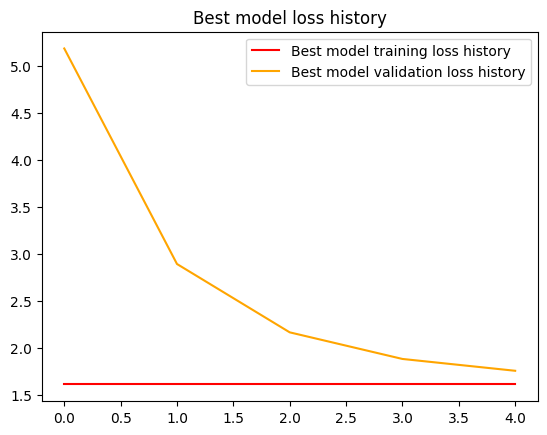

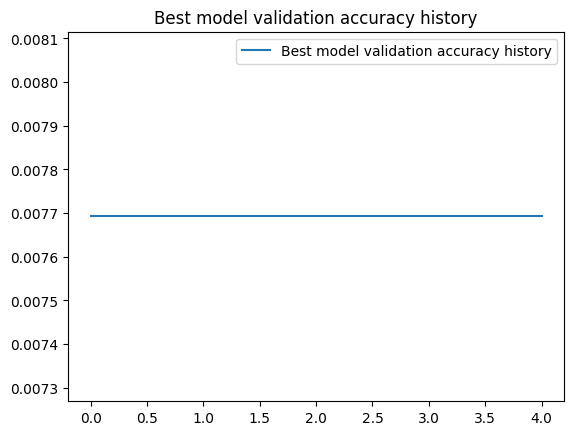


Best Model Training Loss: 1.6068456099583552
Best Model Validation Loss: 1.7526007193785447
Best Model Accuracy: 0.007692307699471712


Fold	Training Loss	Validation Loss	Validation Accuracy
0	1.2282113805126684	68.25836768517128	0.4769230782985687
1	1.6068456099583552	1.7526007193785447	0.007692307699471712

Average Performance Metrics of Model
Average Training Loss 1.4175284952355118
Average Validation Loss 35.005484202274914
Average Validation Accuracy 0.24230769299902022


In [18]:
# get best model
model = get_model(exp_params["model"]["name"])
model = get_saved_model(model, '')
model_info = get_modelinfo('')
best_fold = model_info['results']['fold']
metric_path = os.path.join(config["root_dir"], "models/checkpoints/all_folds_metrics.json")
all_folds_metrics = read_json(metric_path)
print('All folds metrics')
print(all_folds_metrics)

print("\nModel validation results")
print(model_info['results']['trlosshistory'])
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()

In [19]:
#model testing on small test dataset
print("\n\nTesting Saved Model")
metrics = all_folds_metrics[f'{best_fold}'] if exp_params['train']['val_split_method'] == 'k-fold' else all_folds_metrics
mt = ModelTester(model, smfte_dataset, data_transforms, metrics)
mt.test_and_save_csv(class_dict)



Testing Saved Model
Running through test dataset


/content/drive/MyDrive/Personal-Projects/crop-damage-classification/common/utils.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batchlist = list(map(np.array, zip(*batch)))
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the i

	Running through batch 0


/content/drive/MyDrive/Personal-Projects/crop-damage-classification/experiments/test_model.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(normalize(img_batch)))
/content/drive/MyDrive/Personal-Projects/crop-damage-classification/experiments/test_model.py:89: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


In [20]:
'''
#model testing on test dataset
print("\n\nTesting Saved Model")
metrics = all_folds_metrics[f'{best_fold}'] if exp_params['train']['val_split_method'] == 'k-fold' else all_folds_metrics
mt = ModelTester(model, test_dataset, data_transforms, metrics)
mt.test_and_save_csv(class_dict)
'''

'\n#model testing on test dataset\nprint("\n\nTesting Saved Model")\nmetrics = all_folds_metrics[f\'{best_fold}\'] if exp_params[\'train\'][\'val_split_method\'] == \'k-fold\' else all_folds_metrics\nmt = ModelTester(model, test_dataset, data_transforms, metrics)\nmt.test_and_save_csv(class_dict)\n'